In [3]:
# !python --version
# %pip install --upgrade pandas
# %pip install openpyxl
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install plot_keras_history
# %pip install tensorflow
# %pip install keras-tuner==1.0.1

  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-py3-none-any.whl size=73199 sha256=2df11f5cfd95d2569cec0d00cc809f8045685a2f66fdae327e773d3963068ce9
  Stored in directory: c:\users\hecto\appdata\local\pip\cache\wheels\33\f0\c8\218919df808b66696bdb2fbc2261ae74412383483226b0b31d
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492037 sha256=3b275aa8a0a7efe42d939325afcc7d0902ea3de16ee7b458dbeb7f9186385568
  Stored in directory: c:\users\hecto\appdata\local\pip\cache\wheels\63\f1\0c\e56d12b3804345ce5ba34279cbfe583ecafdd1401551457330
Successfully built keras-tuner future
  Attempting uninstall: keras-tuner
    Found existing installation: keras-tuner 1.4.6
    Uninstalling keras-tuner-1.4.6:
      Successfully uninstalled keras-tuner-1.4.6
Note: you may need to restart the kernel to use updated packages.


In [13]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib

import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization


print("TF version:", tf.__version__)
print("KT version:", kt.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Number of measurements to predict
numPredictions = 20

# Number of best models
numBestModels = 1 


# Testing set percentage
test_size = 0.3
# Validation set percentage
val_size = 0.3

# Epochs
epchs = 1000
# Batch size
batch = 1024

# Nodos internos
hidden_nodes = 10

# Units parameters
minUnits = 50
maxUnits = 100
stepsUnits = 25
defaultUnits = 50

# Layers parameters
minLayers = 1
maxLayers = 10
defaultLayers = 3

# Dropout Parameters
minDropout = 0
maxDropout = 0.33
defaultDropout = .25

# Establecer medida de loss
# loss = "mean_squared_error"
loss = "mean_absolute_error"
# loss = "mean_absolute_percentage_error"

# Learning rate
learningRate = [0.0, 1e-2, 1e-3, 1e-4]

# Optimizer objetive: error percetange with the validation set 
objective = kt.Objective('val_mean_absolute_percentage_error', 'min')

# Maximum model trials and executions
trials = 2
executions = 2



Setting GPU Memory Growth...


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TF version: 2.1.0
KT version: 1.0.1
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


In [2]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_30min.xlsx",
                    header = None, 
                    engine = 'openpyxl')[0]

In [14]:

# Data preprocessing: each row will contain the 20 measures for each day , and the 10 measures for the following day
X = pd.DataFrame(np.array(df).reshape(-1, 20))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(21, 41)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(numPredictions)

# Last row is deleted because it is the one used for the real prediction, 
# it is not useful for the training of the model. 
X.drop(X.tail(1).index,inplace=True)
Y.drop(Y.tail(1).index,inplace=True)

print("X Preproccessed shape: ", X.shape)
print("Y Preproccessed shape: ", Y.shape)
print("---------------------------------------------")

#  Uncomment in order to normalize data
# Data Normalization
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=["col_{}".format(i) for i in range(1, 21)])
# Y = pd.DataFrame(scaler.fit_transform(Y), columns=["col_{}".format(i) for i in range(21, 41)])

dfPreproccessed = pd.concat([X, Y], axis=1)

print("DataFrame Preproccessed:")
print(dfPreproccessed)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(X, 
                                                Y, 
                                                test_size = test_size, 
                                                random_state = 0, 
                                                shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, 
                                            yTrain, 
                                            test_size = val_size, 
                                            random_state = 0,
                                            shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], yTrain.shape[1], 1))
xval = np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1))
yval = np.reshape(yVal.values, (yVal.shape[0], yVal.shape[1], 1))
xtest = np.reshape(xTest.values, (xTest.shape[0], xTest.shape[1], 1))
ytest = np.reshape(yTest.values, (yTest.shape[0], yTest.shape[1], 1))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

validation_data = xval.reshape((xval.shape[0], xval.shape[1]))

X Preproccessed shape:  (364, 20)
Y Preproccessed shape:  (364, 20)
---------------------------------------------
DataFrame Preproccessed:
              0           1           2           3           4           5  \
0     96.691833  193.486833  700.986333  587.718333  454.512500  631.489833   
1    202.375667  166.977000  403.916667  340.241000  649.179667  708.682500   
2    109.810167  152.215167   84.124833  134.679500  183.520167  280.223333   
3    385.892667  406.789667  467.582500  380.776333  519.853833  493.757500   
4    278.043000  417.771833  342.662667  375.797833  460.997500  426.551500   
..          ...         ...         ...         ...         ...         ...   
359  366.420667  464.264667  552.852833  619.109000  665.427167  724.307333   
360  195.091333  258.723500  361.770833  478.921833  412.853000  273.145167   
361  290.458000  348.943000  487.557167  453.287500  454.995500  453.921167   
362  194.163333  413.427667  527.695167  358.897000  290.422333  344.84

In [15]:
# Model definition:
with tf.device('/gpu:0'): 
    
    def build_model(hp): 

        model = Sequential()
        
        # model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
        # First layer: LSTM. Number of units optimization
        model.add(LSTM(units = hp.Int('units', 
                                    min_value = minUnits,
                                    max_value = maxUnits, 
                                    step = stepsUnits,
                                    default = defaultUnits),
                        return_sequences = True, 
                        input_shape = (xtrain.shape[1], 1)))

        # Second layer: Dropout with percetange optimization
        model.add(
            Dropout(hp.Float('dropout', 
                            min_value = minDropout,
                            max_value = maxDropout,
                            default = defaultDropout)))
        
        # Last layer:
        model.add(Dense(numPredictions, 
                        activation = "sigmoid"))

        print("Summary: ")
        model.summary()

        # # Set Epsilon to 1, in order to fix huge MAPE values.
        # keras.backend.set_epsilon(1)

        # Model compilation: learning rate optimization
        model.compile(loss = loss,
                    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', 
                                                                values = learningRate)),
                    metrics = [keras.metrics.MAE, 
                            keras.metrics.MAPE, 
                            keras.metrics.MSE])

        return model

        # history = model.fit(
        #     xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
        #     ytrain,
        #     epochs = epchs,
        #     batch_size = batch,
        #     validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
    

In [16]:
# Model training:
with tf.device('/gpu:0'): 
    # Create optimizer
    lstmOptimizer = RandomSearch(build_model, 
                                objective = objective,
                                max_trials = trials, 
                                executions_per_trial = executions)

    # Search space summary
    lstmOptimizer.search_space_summary()

    # Search execution with epochs
    initialTime = time.time()
    lstmOptimizer.search(x = xtrain,
                        y = ytrain, 
                        epochs = epchs,
                        batch_size = batch,
                        validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
    finalTime = time.time()

    # Results summary
    lstmOptimizer.results_summary()

    # Get best model generated
    model = lstmOptimizer.get_best_models(num_models = numBestModels)[0]

    # Model training with epochs 
    history = model.fit(
                xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
                ytrain,
                epochs = epchs,
                batch_size = batch,
                validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))

    # Show model info
    print("Tiempo de entrenamiento (en segundos):\t"+str(finalTime - initialTime))
    print("Tiempo de entrenamiento (en horas):\t"+str((finalTime - initialTime)/3600))
    print(history.history.keys())
    print(model.history.history)
    print(model.history.params)


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
dense (Dense)                (None, 20, 20)            1020      
Total params: 11,420
Trainable params: 11,420
Non-trainable params: 0
_________________________________________________________________


Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 150)           91200     
_________________________________________________________________
dropout (Dropout)            (None, 20, 150)           0         
_________________________________________________________________
dense (Dense)                (None, 20, 20)            3020      
Total params: 94,220
Trainable params: 94,220
Non-trainable params: 0
_________________________________________________________________
Train on 177 samples, validate on 77 samples
Epoch 1/1000
177/177 [==============================] - 3s 17ms/sample - loss: 371.4341 - mean_absolute_error: 371.4341 - mean_absolute_percentage_error: 440309.4375 - mean_squared_error: 185832.3906 - val_loss: 317.9859 - val_mean_absolute_error: 317.9859 - val_mean_absolute_percentage_error: 99.5809 - val_mean_squared_error

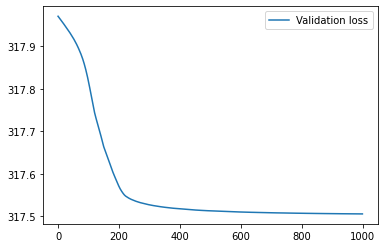

110/110 [==============================] - 0s 128us/sample - loss: 462.6198 - mean_absolute_error: 462.6198 - mean_absolute_percentage_error: 99.5487 - mean_squared_error: 267412.3438
Score: [462.6197548606179, 462.61975, 99.54867, 267412.34]


In [10]:
# Model evaluation:

# Training and Validation loss curves
#plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval)
print('Score:', score)